# Bayesian Network

1. Relevant import statements

In [107]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import HillClimbSearch
from pgmpy.models.BayesianModel import BayesianModel
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import networkx as nx

2. Loading the dataset

In [109]:
file_path = '/content/lymphography_data.csv' # Path of the file uploaded to the session memory
dataset = pd.read_csv(file_path) # Reading the csv file using pandas and creating a dataframe

3. Printing out the dataframe informations to double-check the dataset loaded

In [110]:
dataset.head(3) # This will print the first 3 rows of the dataframe

,Class,Lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
0,3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
1,2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
2,3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7


In [111]:
dataset.tail(3) # This will print the last 3 rows of the dataframe

,Class,Lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
145,3,2,2,1,1,1,2,1,2,1,3,3,3,3,8,3,2,2,4
146,2,2,1,1,1,1,1,1,2,1,2,2,4,2,2,1,2,2,1
147,2,2,2,2,1,2,2,1,2,1,3,3,4,3,4,3,2,2,6


In [112]:
dataset.shape # Printing the shape of the dataframe (rows, columns)

(148, 19)

In [113]:
dataset.info() # This will print more information regarding the dataframe like the columns, number of non null elements present and their data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Class             148 non-null    int64
 1   Lymphatics        148 non-null    int64
 2   block of affere   148 non-null    int64
 3   bl. of lymph. c   148 non-null    int64
 4   bl. of lymph. s   148 non-null    int64
 5   by pass           148 non-null    int64
 6   extravasates      148 non-null    int64
 7   regeneration of   148 non-null    int64
 8   early uptake in   148 non-null    int64
 9   lym.nodes dimin   148 non-null    int64
 10  lym.nodes enlar   148 non-null    int64
 11  changes in lym    148 non-null    int64
 12   defect in node   148 non-null    int64
 13   changes in node  148 non-null    int64
 14  changes in stru   148 non-null    int64
 15  special forms     148 non-null    int64
 16  dislocation of    148 non-null    int64
 17  exclusion of no   148 non-null    i

In [114]:
dataset['Class'].unique() # Getting the unique values of class labels

array([3, 2, 4, 1])

In [115]:
# Now, we find the indices of classes 1 and 4. We will use these indices to later drop the rows with this classification
index_1 = dataset[((dataset.Class == 1))].index
index_4 = dataset[((dataset.Class == 4))].index
print(index_1)
print(index_4)

Int64Index([78, 136], dtype='int64')
Int64Index([14, 36, 44, 139], dtype='int64')


In [116]:
# Droping the rows with the given indices
dataset.drop(index_1, inplace=True)
dataset.drop(index_4, inplace=True)
dataset.shape

(142, 19)

In [117]:
Y = dataset['Class'] # Extracting the class column from the dataset
X = dataset.drop('Class', axis=1) # Dropping the class column so the remaining columns will represent the features (X)

In [118]:
print(X.shape)
print(Y.shape)

(142, 18)
(142,)


4. Splitting the dataset into training and testing

In [119]:
# Train test split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

In [120]:
# Joining the train features and corresponding class to create a single dataframe to represent the training dataset
data = X_train.join(y_train)

In [121]:
data.head(3)

,Lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in,Class
86,2,2,1,1,1,1,1,2,1,2,3,3,3,5,2,1,2,1,2
29,3,1,1,1,1,1,1,1,1,2,2,4,2,8,2,2,2,1,3
42,3,2,2,1,1,2,1,1,1,3,2,3,3,4,3,1,2,2,2


In [122]:
# HillClimbSearch performs a local search based on hill climbing algorithm to estimate the DAG structure that has optimal score according to the scoring method supplied
hc = HillClimbSearch(data)

5. Performing some common score functions on the hill climbing search model to find the best score function

In [123]:
bdeu = BDeuScore(data, equivalent_sample_size=10)
bdeu_model = hc.estimate(scoring_method=bdeu)
print(bdeu_model)
# print(sorted(bdeu_model.nodes()))
# for edge in bdeu_model.edges():
#   print(edge)

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 19 nodes and 32 edges


In [124]:
k2 = K2Score(data)
k2_model = hc.estimate(scoring_method=k2)
print(k2_model)
# print(sorted(k2_model.nodes()))
# for edge in k2_model.edges():
#   print(edge)

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 19 nodes and 30 edges


In [125]:
bic = BicScore(data)
bic_model = hc.estimate(scoring_method=bic)
print(bic_model)
# print(sorted(bic_model.nodes()))
for edge in bic_model.edges():
  print(edge)

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 19 nodes and 18 edges
('block of affere', 'changes in lym')
('bl. of lymph. c', 'block of affere')
('bl. of lymph. c', 'bl. of lymph. s')
('by pass', 'bl. of lymph. c')
('by pass', 'regeneration of')
('extravasates', 'by pass')
('early uptake in', 'lym.nodes enlar')
('lym.nodes enlar', 'extravasates')
(' changes in node', ' defect in node')
('special forms', 'early uptake in')
('dislocation of', 'exclusion of no')
('dislocation of', 'Lymphatics')
('no. of nodes in', 'Class')
('Class', ' changes in node')
('Class', 'special forms')
('Class', 'block of affere')
('Class', 'dislocation of')
('Class', 'regeneration of')


In [126]:
best_model = bic_model # we are choosing the bic model with least number of edges as the best model

6. Creating the bayesian model from the best score model

In [127]:
final_model = BayesianModel(best_model) # create the bayesian model with the best identified model
final_model.fit(data) # fit the data on the model
print(final_model)

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


BayesianModel with 19 nodes and 18 edges


7. Plotting the DAG

<Figure size 432x288 with 0 Axes>

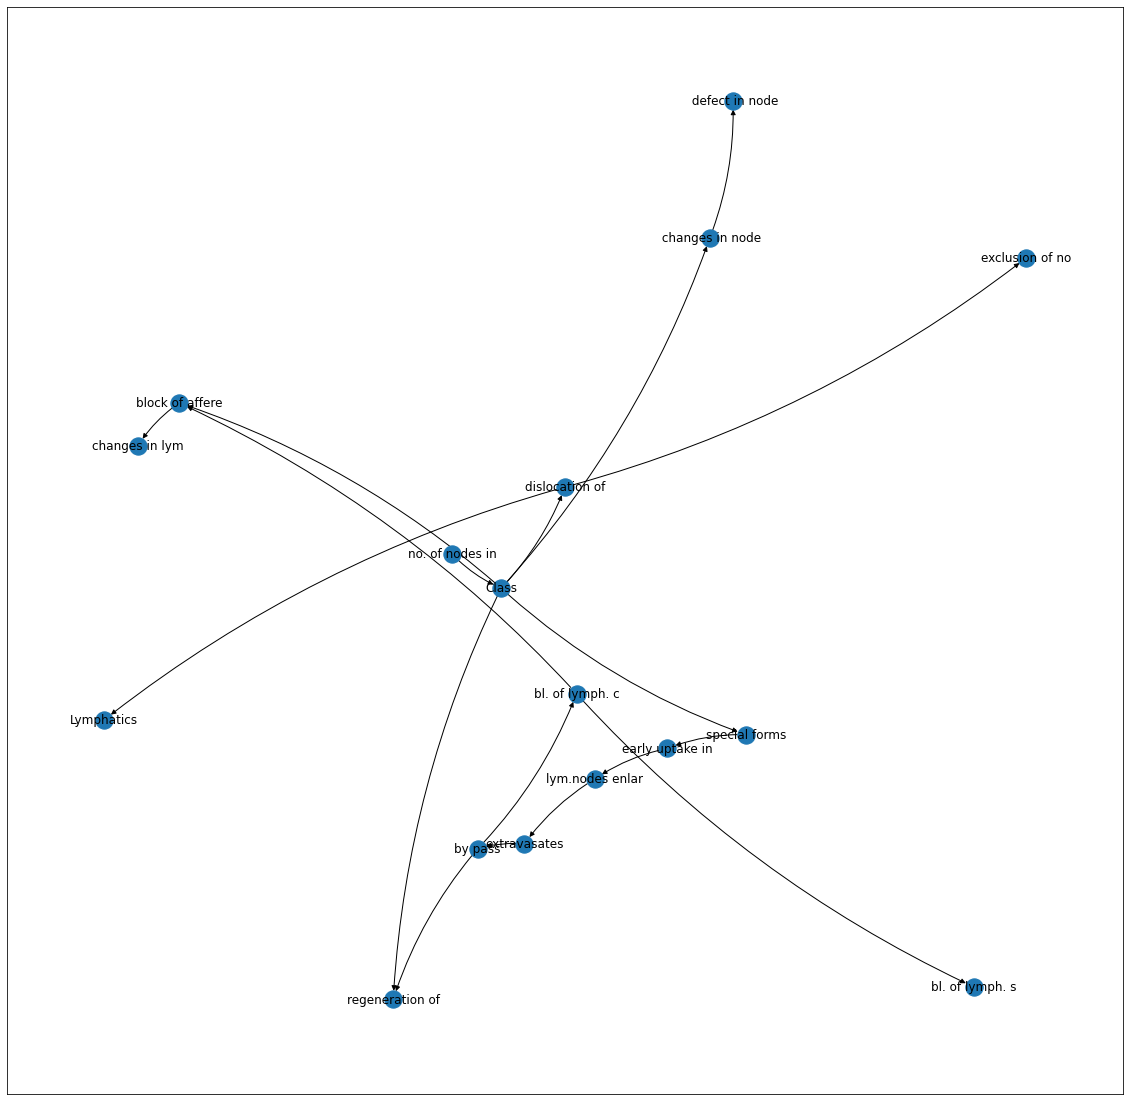

In [128]:
G = nx.MultiDiGraph() # create a multi directional graph object
G.add_edges_from(best_model.edges()) # add the edges to the graph from the best model's edges
plt.tight_layout() # tight layout allows padding between nodes
plt.figure(figsize=(20,20)) # figure size of 20x20
nx.draw_networkx(G, connectionstyle='arc3, rad = 0.1') # plot the graph. connection style uses an arc style so it minimises the overlap of edges in the graph
plt.show()  # show the plot

In [129]:
# we use the variable elimination inference method as it is one of the best methods and it tries to combine multiple variables and create new ones
inference = VariableElimination(final_model)

In [130]:
# F(a, b) and F(b, c) => F'(a, c)

In [131]:
X_test.shape

(43, 18)

In [132]:
X_test.head(2)

,Lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
135,3,2,2,2,2,2,1,2,1,2,3,3,3,4,3,2,2,7
20,3,1,1,1,1,1,1,2,1,2,2,4,2,4,3,2,2,3


In [133]:
# sample code for reference only
print(y_test.iloc[3])
print(type(X_test.iloc[0]))
d = dict(X_test.iloc[0])
print(type(d))

3
<class 'pandas.core.series.Series'>
<class 'dict'>


In [134]:
# we now predict each row the same way as shown below
# we use the query function of the inference variable to predict the class
# what we try to predict is passed as a list in the variables parameter and the the data row instance is passed as the evidence
# since evidence takes in only dictionary, we convert the pandas series to dict by calling the dict conversion method in python
pred = inference.query(variables=['Class'], evidence=dict(X_test.iloc[3]), joint=False)
print(pred['Class'])
print(pred['Class'].values)

+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.0270 |
+----------+--------------+
| Class(3) |       0.9730 |
+----------+--------------+
[0.02702066 0.97297934]


/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


In [135]:
y_pred = [] # initialize an empty predictions list
for i in range(X_test.shape[0]): # for each row in the X_test (from 0 to total number of rows(X_test.shape[0]))
  pred = inference.query(variables=['Class'], evidence=dict(X_test.iloc[i]), joint=False) # predict the class
  if pred['Class'].values[0] > pred['Class'].values[1]: # if the probability in the 0th element of the prediction list is greater than the 1st element
    y_pred.append(2) # add 2 as the predicted class
  else:
    y_pred.append(3) # else add 3

In [136]:
y_pred = pd.Series(y_pred) # to use the predictions in the other metrics function, we convert them to pandas series
print(type(y_pred))

<class 'pandas.core.series.Series'>


[[24  3]
 [ 6 10]]


[Text(0, 0.5, '2'), Text(0, 1.5, '3')]

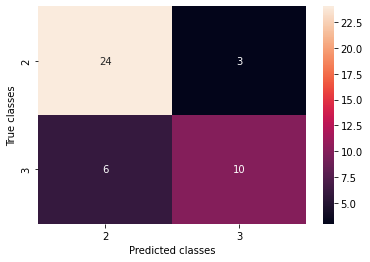

In [137]:
cm = confusion_matrix(y_test, y_pred) # Create confusion matrix
print(cm)

ax = plt.subplot() # create a subplot element
sn.heatmap(cm, annot=True) # create a heatmap (a colored rectangle) with annot = True to print the numbers inside the squares

# set axes labels
ax.set_xlabel('Predicted classes')
ax.set_ylabel('True classes')

# set labels to each squares along the axis
ax.xaxis.set_ticklabels(['2', '3'])
ax.yaxis.set_ticklabels(['2', '3'])

In [138]:
# Precision means What proportion of predicted positives was actually correct?
# Recall means What proportion of actual positives was predicted correctly?

# Precision = TP / (TP + FP) => 24 / (24 + 6)
# Recall = TP / (TP + FN) => 24 / (24 + 3)
# f1 = mean of precision and recall [(precision + recall) / 2]

In [139]:
print(classification_report(y_test, y_pred))
print("Accuracy", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.80      0.89      0.84        27
           3       0.77      0.62      0.69        16

    accuracy                           0.79        43
   macro avg       0.78      0.76      0.77        43
weighted avg       0.79      0.79      0.79        43

Accuracy 0.7906976744186046
